In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import xml.etree.ElementTree as et 
from bs4 import BeautifulSoup

# !pip install wordcloud
from wordcloud import WordCloud

from nltk.corpus import stopwords
import string


from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import  TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer


from  nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
import nltk

In [20]:
# READ THE DATA (without modifications)
path = "pan21/es/"
rows = []
for root, dirs, files in os.walk(path):
    for filename in files:
        if 'xml' in filename:
            tweets_raw = []
            tree = et.parse(path+filename)
            root = tree.getroot()
            classe = root.attrib['class']
            readXML = BeautifulSoup(open(path+filename),'xml')
            tweets = readXML.findAll('document')
            for tweet in tweets:
                tweets_raw.append(tweet.text)
            tweets_raw = ' '.join(tweets_raw)
            df_cols = ["ID","class","tweets"]
            rows.append({"ID": filename.split(".")[0],"class": classe, "tweets":tweets_raw})

out_df = pd.DataFrame(rows, columns = df_cols)

In [21]:
out_df

,ID,class,tweets
0,3688ad73102afe52d9f4276dd6088982,1,RT #USER#: Pablo Iglesias le pone los cuernos ...
1,fa5be6e6c139255df5fabafa5812a062,0,RT #USER#: a dormir y recuerden que barovero l...
2,0fab59fda6ff79ea1fea239e07549d58,1,Pero el bar de pueblo donde van a jugar 10 vie...
3,52bb592ba4afc50f0d5deb9261067aec,1,#USER# Cuántos mueren asesinados por narcos en...
4,73d27667ca07f3857b495aed5282ec52,1,RT #USER#: Motín en Ciudadanos: tres diputados...
...,...,...,...
195,73f77721bb14a116951e65daa1bc1d4a,0,Cuidado si no me invitan a sus llamaditas Oiga...
196,0af3ad19d2571df4cbca1948aba1019e,0,#USER# magnífico su resumen de esta semana 👏👏👏...
197,5a079a4ef5989015391fbb1b2ebc5145,0,Estoy 1 hora sin estudiar y ya me siento culpa...
198,8e4e83695f93d385b31a2e50eb595085,0,El demócrata #USER# no quiere elecciones. #USE...


/home/jorge/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

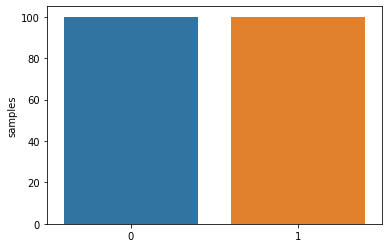

In [25]:
# Class Distribution
x=out_df["class"].value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

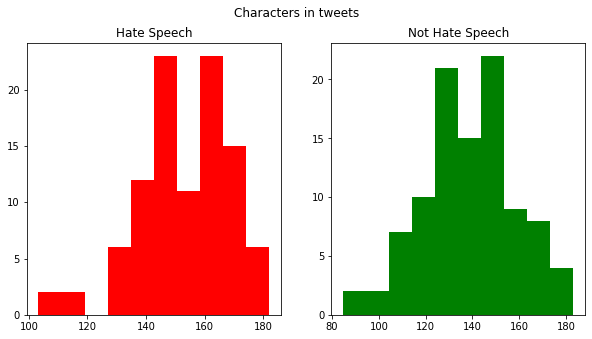

In [53]:
# Number of chars in tweets
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tweet_len = out_df.loc[out_df['class'] == '1']['tweets'].str.len() / 100
ax1.hist(tweet_len,color='red')
ax1.set_title('Hate Speech')

tweet_len = out_df.loc[out_df['class'] == '0']['tweets'].str.len() / 100
ax2.hist(tweet_len,color='green')
ax2.set_title('Not Hate Speech')


fig.suptitle('Characters in tweets')
plt.show()

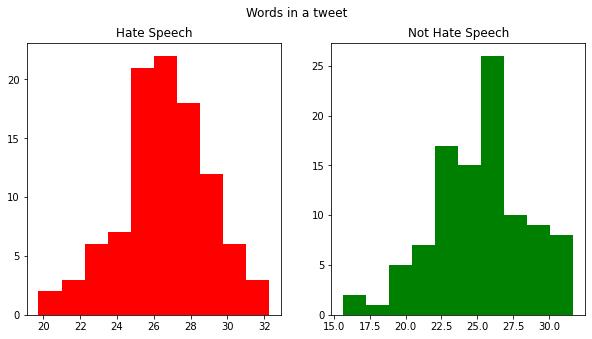

In [54]:
# Number of words in tweets
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tweet_len= out_df.loc[out_df['class'] == '1']['tweets'].str.split().map(lambda x: len(x) / 100)
ax1.hist(tweet_len,color='red')
ax1.set_title('Hate Speech')

tweet_len= out_df.loc[out_df['class'] == '0']['tweets'].str.split().map(lambda x: len(x) / 100)
ax2.hist(tweet_len,color='green')
ax2.set_title('Not Hate Speech')

fig.suptitle('Words in a tweet')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

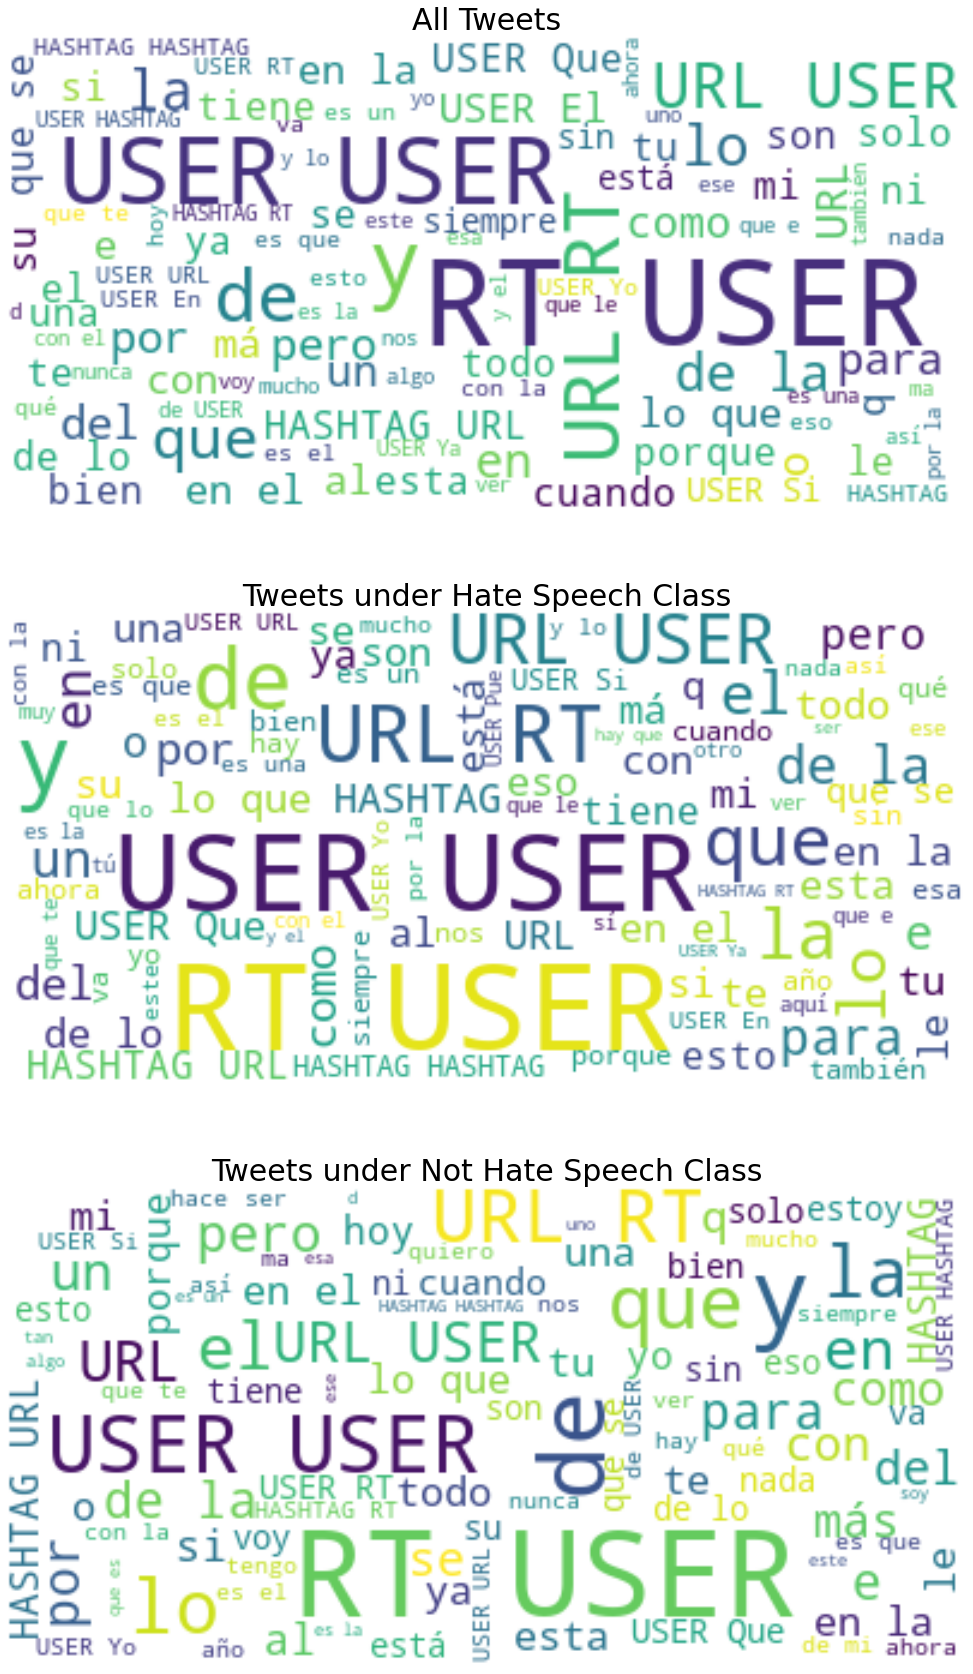

In [74]:
df_HS = out_df.loc[out_df['class']=="1"]
df_NHS = out_df.loc[out_df['class']=="0"]
tweet_All = " ".join(review for review in out_df["tweets"])
tweet_HS = " ".join(review for review in df_HS["tweets"])
tweet_NHS = " ".join(review for review in df_NHS["tweets"])

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_HS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_HS)
wordcloud_NHS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_NHS)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_HS, interpolation='bilinear')
ax[1].set_title('Tweets under Hate Speech Class',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_NHS, interpolation='bilinear')
ax[2].set_title('Tweets under Not Hate Speech Class',fontsize=30)
ax[2].axis('off')

In [5]:
# Cleaning Data

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return re.sub(emoji_pattern,' #emoji# ',text)

spanish_stopword = stopwords.words('spanish')
spanish_stopword.remove("no")
spanish_stopword.extend(["url","user","hashtag","url","emoji","rt"])
# print(spanish_stopword)

def remove_punct(text):
#     print(string.punctuation)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def remove_stopwords(text):
#     print(text)
    text = [word for word in text.split() if word not in spanish_stopword]
#     print(text)
    return text



def Clean_tweet(text):
#   lowerize
    Cleantweet = text.lower()
#     remove emojis
    Cleantweet = remove_emoji(Cleantweet)
#     remove punctuaction '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    Cleantweet = remove_punct(Cleantweet)
#     delete stopwords
    Cleantweet = remove_stopwords(Cleantweet)
#     print(Cleantweet)
    Cleantweet = " ".join([word for word in Cleantweet])
    return Cleantweet


path = "pan21/es/"
rows = []
for root, dirs, files in os.walk(path):
    for filename in files:
        if 'xml' in filename:
            tweets_raw = []
            tree = et.parse(path+filename)
            root = tree.getroot()
            classe = root.attrib['class']
            readXML = BeautifulSoup(open(path+filename),'xml')
            tweets = readXML.findAll('document')
            for tweet in tweets:
                tweet = Clean_tweet(tweet.text)
#                 print(tweet)
                tweets_raw.append(tweet)
            tweets_raw = ' '.join(tweets_raw)
            df_cols = ["ID","class","tweets"]
            rows.append({"ID": filename.split(".")[0],"class": classe, "tweets":tweets_raw})

            
            
Cleandf = pd.DataFrame(rows, columns = df_cols)
Cleandf.to_csv('pan21/ES_CleanDataset.csv', sep='\t', index=False)
Cleandf

,ID,class,tweets
0,3688ad73102afe52d9f4276dd6088982,1,pablo iglesias pone cuernos montero internacio...
1,fa5be6e6c139255df5fabafa5812a062,0,dormir recuerden barovero hizo goles boca no s...
2,0fab59fda6ff79ea1fea239e07549d58,1,bar pueblo van jugar viejos domino cerradoque ...
3,52bb592ba4afc50f0d5deb9261067aec,1,cuántos mueren asesinados narcos favelas hace ...
4,73d27667ca07f3857b495aed5282ec52,1,motín ciudadanos tres diputados no apoyarán mo...
...,...,...,...
195,73f77721bb14a116951e65daa1bc1d4a,0,cuidado si no invitan llamaditas oigan si verd...
196,0af3ad19d2571df4cbca1948aba1019e,0,magnífico resumen semana buenas noches buen de...
197,5a079a4ef5989015391fbb1b2ebc5145,0,hora estudiar siento culpable enferma pregunta...
198,8e4e83695f93d385b31a2e50eb595085,0,demócrata no quiere elecciones no pruebas tamp...


In [6]:
pipeline = Pipeline([('vect', TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=True)),
                ('lr', LogisticRegression(penalty='l2', solver='liblinear',verbose=0, random_state=5))])

parameters={"vect__ngram_range": [(1,1),(1,2)],
            "vect__min_df":[6,7,8,9],
            "lr__C":[10000,100000]}

grid_search=GridSearchCV(pipeline, parameters, cv=StratifiedKFold(10,shuffle=True, random_state=0),n_jobs=-1)

lr_tfidfA=grid_search.fit(Cleandf["tweets"],Cleandf['class'])

import pickle
bdf=pd.DataFrame()
bdf['params']=lr_tfidfA.cv_results_['params']
bdf['scores']=lr_tfidfA.cv_results_['mean_test_score']
bdf.to_csv('pan21/ES_lr_tfidf_resultsCleanDataset3.tsv', sep='\t', index=False)

(-0.5, 399.5, 199.5, -0.5)

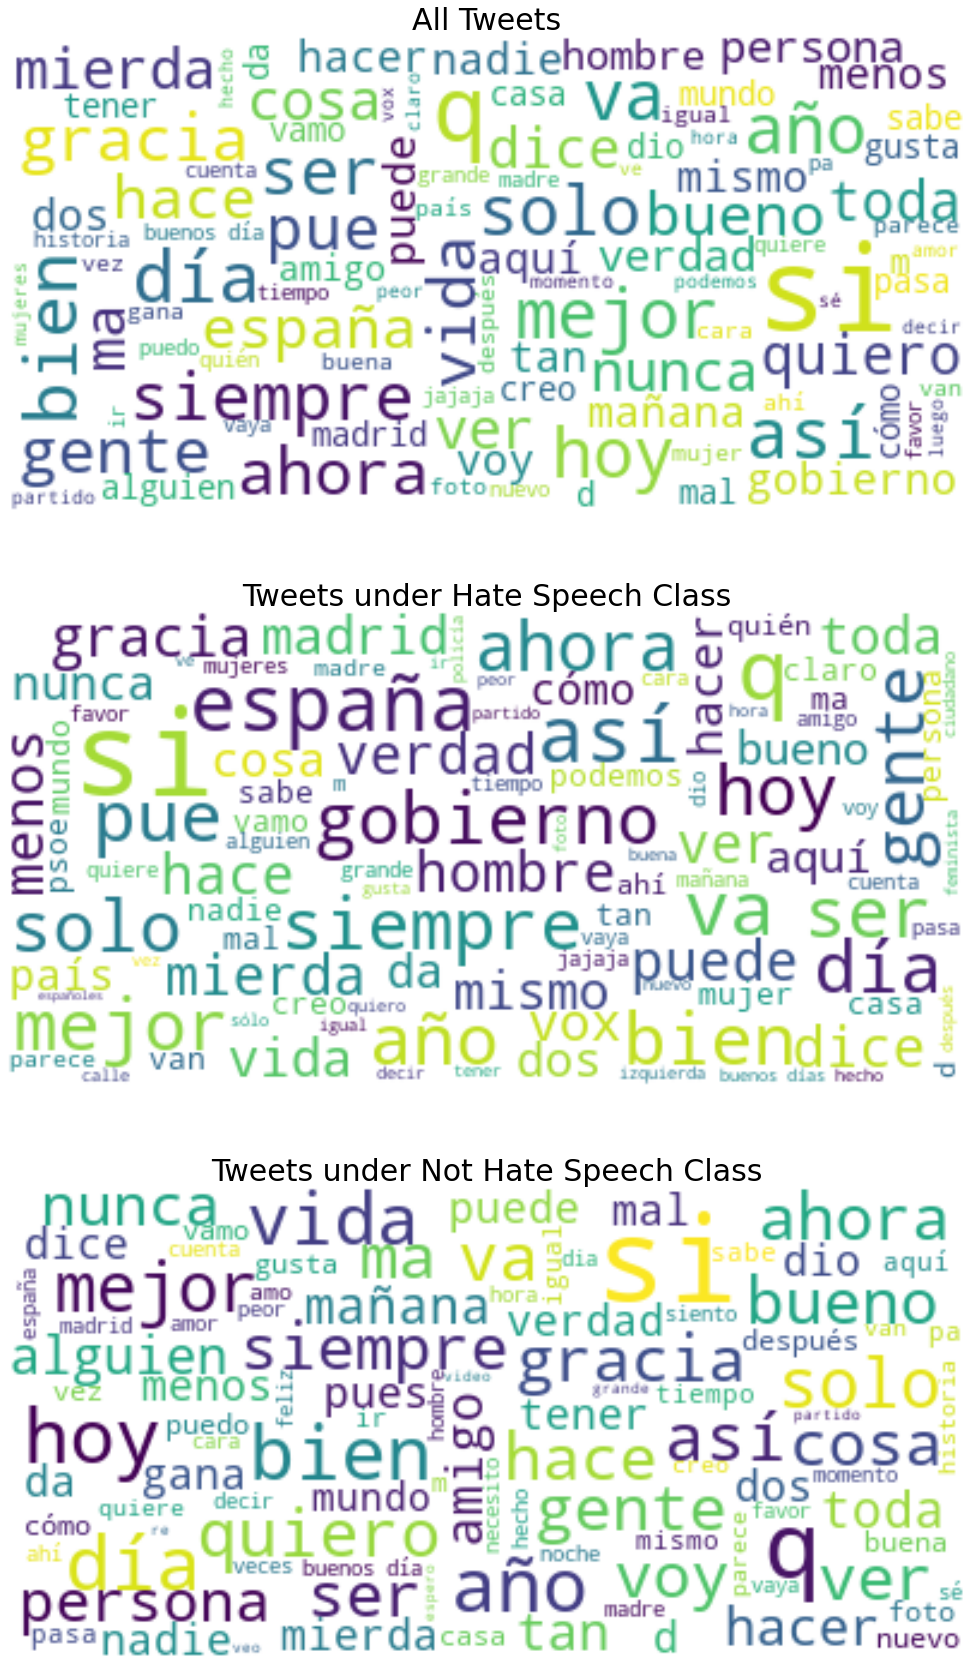

In [39]:
df_HS = Cleandf.loc[Cleandf['class']=="1"]
df_NHS = Cleandf.loc[Cleandf['class']=="0"]
tweet_All = " ".join(review for review in Cleandf["tweets"])
tweet_HS = " ".join(review for review in df_HS["tweets"])
tweet_NHS = " ".join(review for review in df_NHS["tweets"])

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_HS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_HS)
wordcloud_NHS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_NHS)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_HS, interpolation='bilinear')
ax[1].set_title('Tweets under Hate Speech Class',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_NHS, interpolation='bilinear')
ax[2].set_title('Tweets under Not Hate Speech Class',fontsize=30)
ax[2].axis('off')

In [1]:
# Show unigrams, bigrams, trigrams